In [ ]:
%load_ext autoreload
%autoreload 2

## Test pipeline on one instance


In [240]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
import matplotlib.pyplot as plt
import numpy as np
import crepe

import utils as u
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [241]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"

audio_file_path = "audios/tj1.wav"
pitch_est = PitchEstimator()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

spectrogram = np.abs(librosa.stft(y))

# Use median filtering to divide harmonic from percussive component
# NOTE: you can change margin and kernel_size and see the effect
# margin is related to the wiener-soft-mask
# kernel is the size of the filters that go over the spectrogram
harmonic, percussive = librosa.decompose.hpss(spectrogram, margin=16, kernel_size=31)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print("Harmonic component:")
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print("Percussive component:")
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


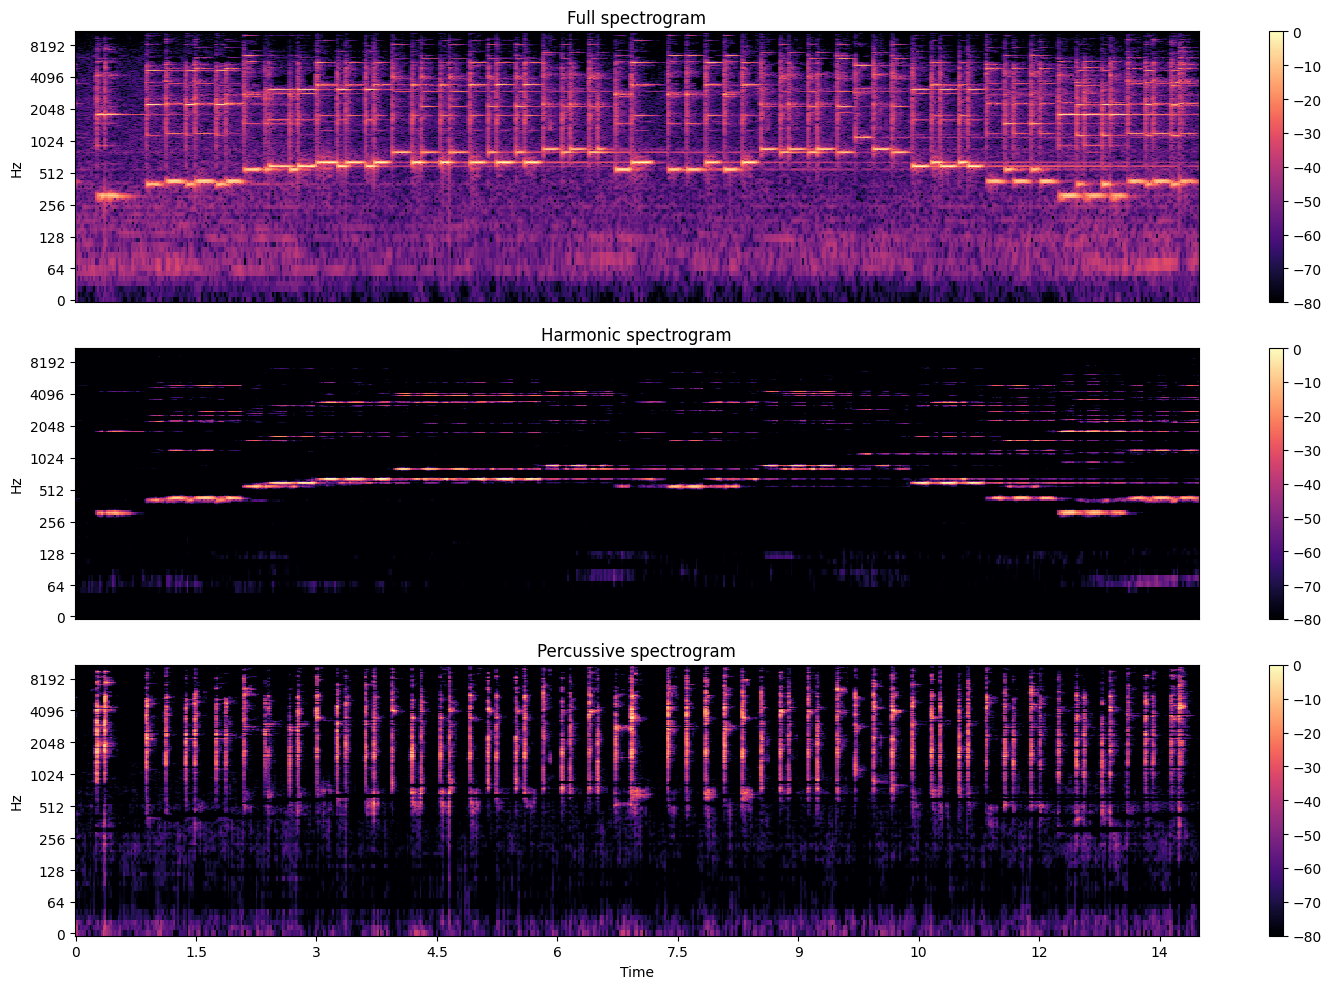

In [242]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

In [243]:
# comps, acts = librosa.decompose.decompose(spectrogram)

In [244]:
# librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis="log")

In [245]:
# librosa.display.specshow(librosa.amplitude_to_db(acts, ref=np.max), y_axis="log")

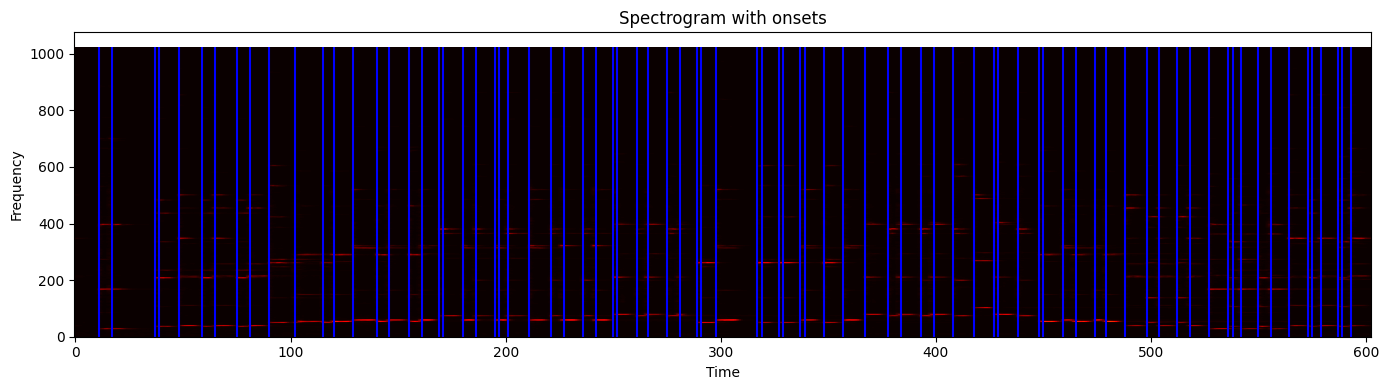

In [246]:
onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect="auto", origin="lower", cmap="hot")

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color="blue", linestyle="-")

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.set_title("Spectrogram with onsets")

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [247]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [248]:
time, frequency, confidence, activation = crepe.predict(harmonic_audio, sr, viterbi=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step


## Comparing CREPE with DSP techiniques

In [249]:
def detect_pitch(S, sr):
    # https://stackoverflow.com/questions/43877971/librosa-pitch-tracking-stft"""
    pitches, magnitudes = librosa.core.piptrack(S=S, sr=sr, fmin=75, fmax=1600)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

pitches_dsp = detect_pitch(S=harmonic, sr=sr)

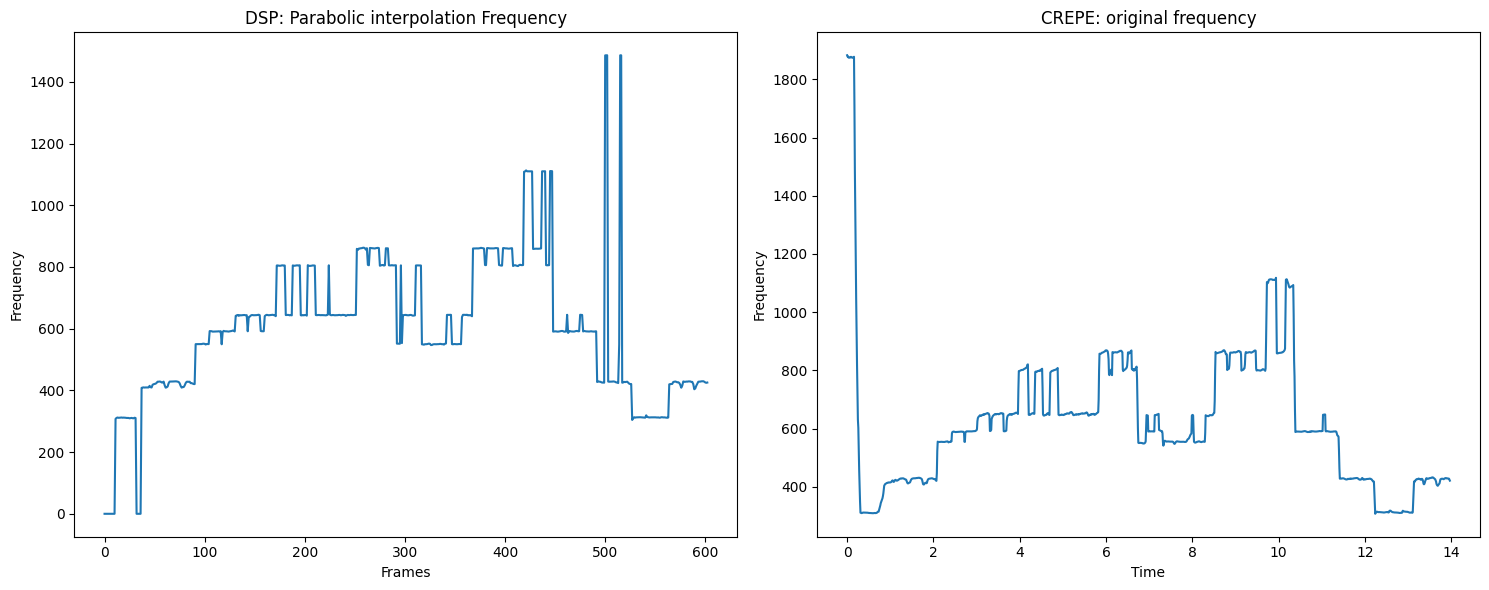

In [250]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6))

frames = np.arange(len(pitches_dsp))
# Plot new_frequency
ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency")
ax.set_title("DSP: Parabolic interpolation Frequency")

# Plot frequency
ax2.plot(time, frequency)
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")
ax2.set_title("CREPE: original frequency")

plt.tight_layout()
plt.show()

In [251]:
def find_stable_regions(frequencies, window_size, threshold):
    stable_regions = []
    segments = []
    for i in range(len(frequencies) - window_size + 1):
        segment = frequencies[i:i+window_size]
        std_dev = np.std(segment)
        if std_dev < threshold:
            stable_regions.append((i, i+window_size))
            # segments.append( ( np.mean(segment), np.median(segment) ) )
            segments.append(round(np.mean(segment), 2))
    return stable_regions, segments


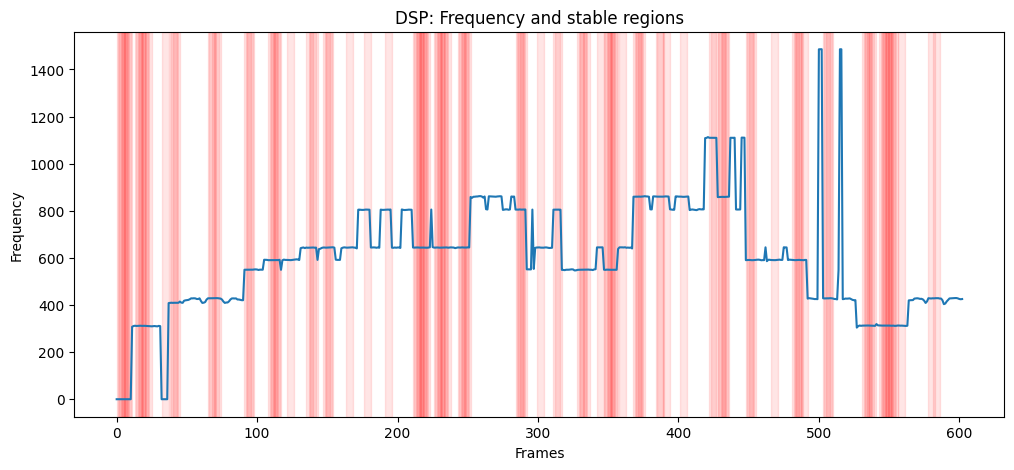

In [252]:
# windows size and threshold can be tweaked
stable_r, segs = find_stable_regions(frequencies=pitches_dsp, window_size=5, threshold=0.4)
fig, ax = plt.subplots(figsize=(12,5))

# Plot the frequency values
ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency")
ax.set_title("DSP: Frequency and stable regions")

for start, end in stable_r:
    plt.axvspan(start, end, color='red', alpha=0.1)

plt.show()

In [253]:
# new_frequency = frequency.copy()
# new_frequency[confidence < 0.6] = 0

In [254]:
# fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot new_frequency
# ax.plot(time, new_frequency)
# ax.set_xlabel("Time")
# ax.set_ylabel("Frequency")
# ax.set_title("New Frequency")

# # Plot frequency
# ax2.plot(time, frequency)
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Frequency")
# ax2.set_title("Original Frequency")

# plt.tight_layout()
# plt.show()

In [255]:
# tones = []
# stable_segments_idxs = []


# for i, onset in enumerate(onsets):
#     index_a = np.argmax(time > onset)
#     if i == len(onsets) - 1:
#         index_b = len(time) - 1
#     else:
#         index_b = np.argmax(time > onsets[i + 1])

#     frequency_segment = new_frequency[index_a:index_b]
#     no_zero_seg = frequency_segment[frequency_segment != 0]
#     # print(frequency_segment)
#     # print(no_zero_seg)

#     tone = np.median(frequency_segment)
#     # tone = np.median(frequency_segment[frequency_segment > 0])
#     if tone == 0:
#         continue
#     print(f"Onset median {i}-{i+1}: {tone}")

#     print("----------")
#     tones.append(tone)

In [256]:
# tone_group = u.group_and_average_frequencies(tones)
tone_group = u.group_and_average_frequencies(segs)

def filter_list(input_list):
    return [item for item in input_list if 80 <= item <= 2000]

tone_group = filter_list(tone_group)

In [257]:
# for tone in tone_group:
#     audio = librosa.tone(tone, duration=1)
#     print(f"Playing tone {tone}")
#     display(ipd.Audio(audio, rate=sr))

wait_time = 0.5
audio = np.array([])
for tone in tone_group:
    tone_audio = librosa.tone(tone, duration=1)
    wait_audio = np.zeros(int(wait_time * sr))
    audio = np.concatenate((audio, tone_audio, wait_audio))

print("Playing concatenated audio:")
display(ipd.Audio(audio, rate=sr))

Playing concatenated audio:


## Find out the tuning


In [258]:
def compute_distance(tone_a, tone_b):
    distance_in_cents = 1200 * np.log2(tone_b / tone_a)
    return distance_in_cents

distances = []

for i in range(len(tone_group) - 1):
    tone_a = tone_group[i]
    tone_b = tone_group[i + 1]
    d = compute_distance(tone_a, tone_b)
    print(f"Distance between {tone_a} and {tone_b}: {d} cents")
    distances.append(d)

Distance between 312.1981797651811 and 409.3433329264323: 469.0191265514435 cents
Distance between 409.3433329264323 and 428.59777492947046: 79.57555471512099 cents
Distance between 428.59777492947046 and 549.7723106971154: 431.05186443123415 cents
Distance between 549.7723106971154 and 590.9153401692708: 124.94064538500561 cents
Distance between 590.9153401692708 and 643.9486653645833: 148.79307795571088 cents
Distance between 643.9486653645833 and 805.0412445068359: 386.5404180004906 cents
Distance between 805.0412445068359 and 859.7108306884766: 113.74653980104374 cents
Distance between 859.7108306884766 and 1109.9400024414062: 442.2699689234578 cents


In [259]:
scale_successful = False
for i in range(len(distances) - 1):
    if distances[i] < 200 and distances[i + 1] < 200:
        print(f"Found two consecutive values smaller than 220: {distances[i]} and {distances[i+1]}")
        scale = tone_group[i : i + 6]

        if len(scale) < 6:
            print(f"Could not find a complete scale... only found {len(scale)} tones")
            break
        
        scale_successful = True # TODO: fix this, as it is not necessarily true at this point

        print("---")
        ding, dong, deng, dung, dang, hiding = scale
        print(f"Ding: {ding}")
        print(f"Dong: {dong}")
        print(f"Deng: {deng}")
        print(f"Dung: {dung}")
        print(f"Dang: {dang}")
        print(f"Hiding: {hiding}")
        print("---")
        scale_distances = np.array(distances[i : i + 5])
        print(f"Scale distances: {scale_distances}")

Found two consecutive values smaller than 220: 124.94064538500561 and 148.79307795571088
---
Ding: 549.7723106971154
Dong: 590.9153401692708
Deng: 643.9486653645833
Dung: 805.0412445068359
Dang: 859.7108306884766
Hiding: 1109.9400024414062
---
Scale distances: [124.94064539 148.79307796 386.540418   113.7465398  442.26996892]


In [260]:
if scale_successful:
    begbeg = np.array([120, 114, 432, 81, 453])
    sedang = np.array([136, 155, 379, 134, 396])
    tirus = np.array([197, 180, 347, 104, 372])

    similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
    max_similarity = np.max(similarity)
    print(f"Cosine similarity to begbeg: {similarity[0]}{' *winner*' if similarity[0] == max_similarity else ''}")
    print(f"Cosine similarity to sedang: {similarity[1]}{' *winner*' if similarity[1] == max_similarity else ''}")
    print(f"Cosine similarity to tirus: {similarity[2]}{' *winner*' if similarity[2] == max_similarity else ''}")
    print("-------")

    eucl_distances = euclidean_distances(X=[scale_distances], Y=[begbeg, sedang, tirus])[0]
    min_distance = np.min(eucl_distances)
    print(f"Euclidian distance to begbeg: {eucl_distances[0]}{' *winner*' if eucl_distances[0] == min_distance else ''}")
    print(f"Euclidian distance to sedang: {eucl_distances[1]}{' *winner*' if eucl_distances[1] == min_distance else ''}")
    print(f"Euclidian distance to tirus: {eucl_distances[2]}{' *winner*' if eucl_distances[2] == min_distance else ''}")
    print("-------")

    def gaussian_kernel(x, y, sigma=100):
        distance_squared = np.sum((x - y) ** 2)
        kernel_value = np.exp(-distance_squared / (2 * sigma**2))
        return kernel_value

    gaussian_results = {
        'begbeg': gaussian_kernel(scale_distances, begbeg),
        'sedang': gaussian_kernel(scale_distances, sedang),
        'tirus': gaussian_kernel(scale_distances, tirus)
    }
    max_similarity = max(gaussian_results.values())
    for key, value in gaussian_results.items():
        print(f"Gaussian similarity to {key}: {value}{' *winner*' if value == max_similarity else ''}")

Cosine similarity to begbeg: 0.9952031984065971
Cosine similarity to sedang: 0.9973943066248624 *winner*
Cosine similarity to tirus: 0.9854115837816564
-------
Euclidian distance to begbeg: 67.0000841929891
Euclidian distance to sedang: 52.619443018666836 *winner*
Euclidian distance to tirus: 112.97225675916384
-------
Gaussian similarity to begbeg: 0.7989550727920245
Gaussian similarity to sedang: 0.8707152408381805 *winner*
Gaussian similarity to tirus: 0.528275928531941
